In [6]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [7]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Code/potato-disease/training/PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [9]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [10]:
len(dataset)


68

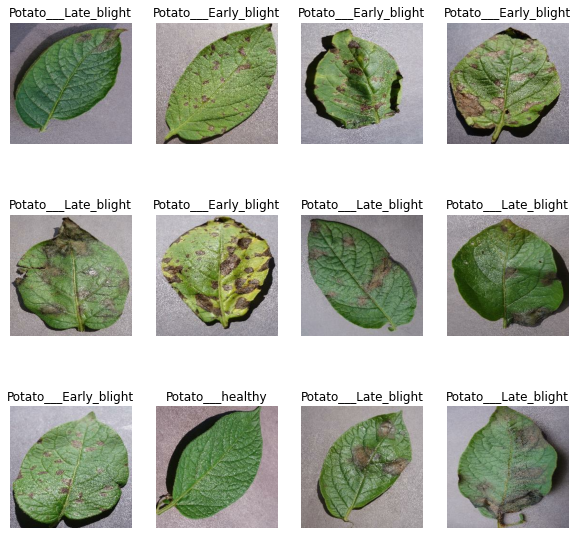

In [11]:
##visualize this image
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [12]:
##80% ==> training
##20% ==> 10% validation , 10%test

In [13]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [14]:
train_ds = dataset.take(54)
len(train_ds)

54

In [15]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [16]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [17]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [18]:
##actual test datasets
test_ds = test_ds.skip(6)
len(test_ds)

8

In [19]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    
    return train_ds, val_ds, test_ds

In [20]:
train_ds , val_ds , test_ds = get_dataset_partitions_tf(dataset)

In [21]:
len(train_ds)

54

In [22]:
len(val_ds)

6

In [23]:
len(test_ds)

8

In [24]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [25]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [26]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [27]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)


In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [29]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [30]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1, epochs=50,)

Epoch 1/50
54/54 [==============================] - 88s 1s/step - loss: 0.9001 - accuracy: 0.4954 - val_loss: 0.9115 - val_accuracy: 0.6719
Epoch 2/50
54/54 [==============================] - 79s 1s/step - loss: 0.7498 - accuracy: 0.6840 - val_loss: 0.5291 - val_accuracy: 0.7448
Epoch 3/50
54/54 [==============================] - 89s 2s/step - loss: 0.4253 - accuracy: 0.8270 - val_loss: 0.2788 - val_accuracy: 0.8854
Epoch 4/50
54/54 [==============================] - 82s 2s/step - loss: 0.3200 - accuracy: 0.8756 - val_loss: 0.2041 - val_accuracy: 0.9167
Epoch 5/50
54/54 [==============================] - 86s 2s/step - loss: 0.3049 - accuracy: 0.8721 - val_loss: 0.2412 - val_accuracy: 0.8802
Epoch 6/50
54/54 [==============================] - 96s 2s/step - loss: 0.2226 - accuracy: 0.9120 - val_loss: 0.2106 - val_accuracy: 0.9167
Epoch 7/50
54/54 [==============================] - 83s 2s/step - loss: 0.2398 - accuracy: 0.9045 - val_loss: 0.1043 - val_accuracy: 0.9740
Epoch 8/50
54/54 [==

In [31]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 8s 479ms/step - loss: 0.0020 - accuracy: 1.0000


In [32]:
scores

[0.0019558798521757126, 1.0]

In [33]:
history

In [34]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [35]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

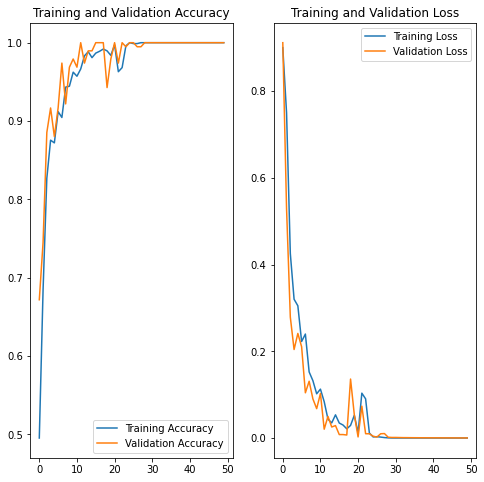

In [37]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [38]:
#run prediction on a sample images

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 407ms/step
predicted label: Potato___Early_blight


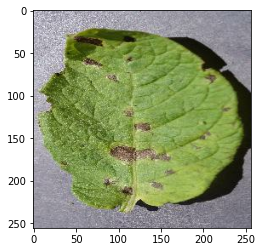

In [48]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [40]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 48ms/step


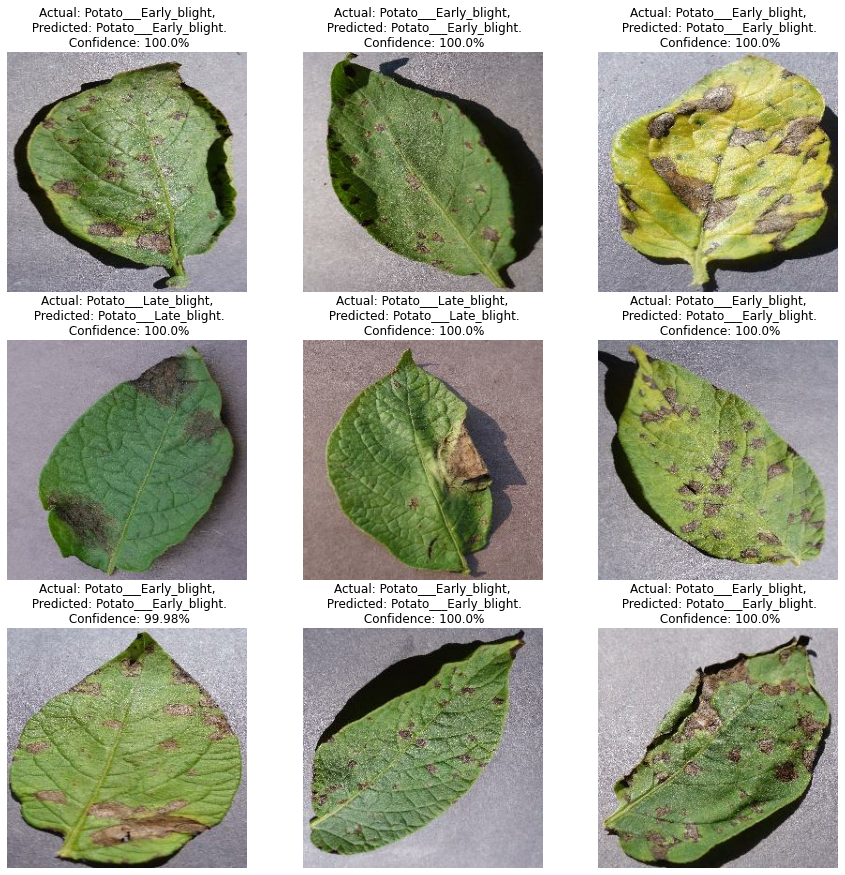

In [52]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")